<a href="https://colab.research.google.com/github/malinphy/Embedding_calls/blob/main/small_BERT_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import os 
import shutil


!pip install tensorflow_text
import tensorflow_text as text
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import losses 
from tensorflow.keras import preprocessing
from platform import python_version

In [ ]:
print('Tensorflow version : ', tf.__version__)
print('Python Version : ',python_version())

Tensorflow version :  2.4.0
Python Version :  3.6.9


In [ ]:
## Loading the IMDB dataset 

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset =tf.keras.utils.get_file(
                                 'aclImdb_v1.tar.gz',
                                 url,
                                 untar =True,
                                 cache_dir = '.',
                                 cache_subdir = ''
                                 )

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'README', 'imdb.vocab', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'unsupBow.feat',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt']

test_dir = os.path.join(dataset_dir,'test')
os.listdir(test_dir)

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=  batch_size ,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
    

)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review',  text_batch.numpy()[i])
    print('label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed


)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

class_names = raw_train_ds.class_names
train_ds =raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)

val_ds = raw_val_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = raw_test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
#### Loading BERT model from TensorFlow Hub
### At this step, small BERT model will be used. L,H,A parameters were defined at the original paper
## L = number of the hidden layer
## H = number of nodes at total hidden layer 
## A = number of attention head 
## L,A,H CHECK THEM AGAIN !!!!!!!!!!!!!!!

selected_BERT_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
## At this step prpeocessor and the encoder model will be called from the TensorFlow Hub


tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing model!']
text_preprocessed = bert_preprocess_model(text_test)

In [ ]:
#### define the model


def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))


tf.Tensor([[0.53243226]], shape=(1, 1), dtype=float32)


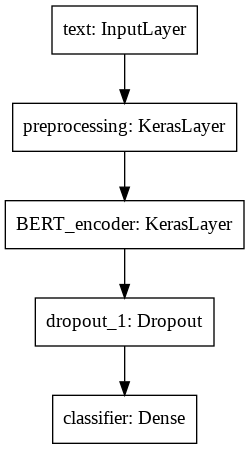

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(
    # from_logits=True
    )
metrics = tf.metrics.BinaryAccuracy()


In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


NameError: ignored